# #402 Concrete Culvert - 3D Thick Shell
<i>Basic box culvert on spring foundations - This is a simple example of creating a model through the LPI, it is not an example of how such a structure should be analysed. Only basic loadcases are considered.</i>
***

![Preview](../_img/jupyter_notebook_402.png)


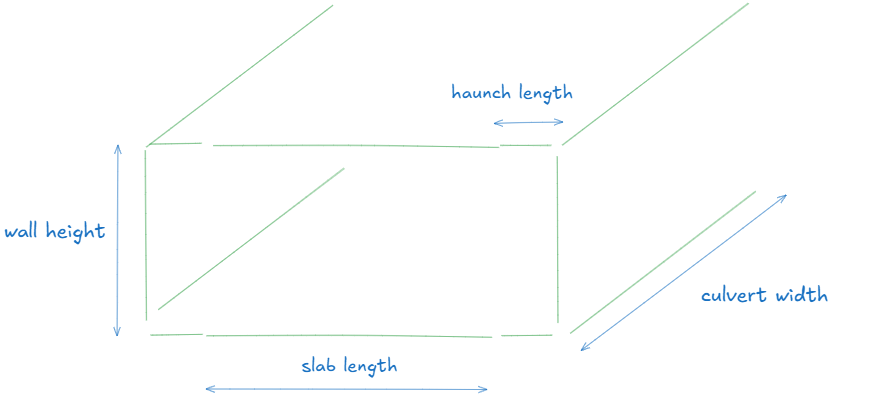

In [ ]:
# Geometry
wall_height = 2.5
wall_thickness = 0.3
slab_length = 2.5
slab_thickness = 0.45
haunch_length = 1
haunch_thk = 0.65
culvert_width = 10

# Element mesh
mesh_size = 1

ground_stiffness = 2000

# Loading
density_fill = 20
height_fill = 1.5
ka = 0.43

vertical_fill_pressure   = density_fill*height_fill # Fill over the culvert
horiz_soil_pressure_top  = vertical_fill_pressure*ka  # Top of the walls
horiz_soil_pressure_base = horiz_soil_pressure_top + (wall_height*density_fill)*ka # Bottom of the walls
surcharge_pressure = 10

# Moving load
ref_path_y_coords = {3, 7} # reference paths for moving loads
patch_width = 4
patch_length = 2
patch_pressure = 50



In [ ]:
import sys; sys.path.append('../') # Reference modules in parent directory
from shared.LPI import *
lusas = get_lusas_modeller()

import shared.Helpers as Helpers
Helpers.initialise(lusas)

if lusas.existsDatabase() and lusas.db().isModified():
    raise Exception("This script will create a new model. Please save or close the current model and try again")

# Create a new model
lusas.newProject("Structural","Basic Concrete Culvert")
# Get the database
db = lusas.database()
# 3D model with Z vertical
db.setAnalysisCategory("3D")
db.setVerticalDir("Z")
# Units
db.setModelUnits("kN,m,t,s,C")

lusas.view().setIsometric()



Create the attributes

In [ ]:
# Shell mesh attribute, thick shell elements
shell_mesh_attr    = db.createMeshSurface("SMsh1").setRegularSize("QTS4", mesh_size, True)

# Concrete material attribute
concrete_mat_attr = db.createIsotropicMaterial("Concrete", 34.8E6, 0.2, 2.4, 12e-6)

# Support attributes
ground_spring_attr = db.createSupportStructural("Ground Spring").setStructural("F", "F", "S", "F", "F", "F", "F", "F", "C", "F") # F=Free, R=Restrained
ground_spring_attr.setSpring("Area", 0,0,ground_stiffness,0,0,0,0,0,0)

In [ ]:
portal1_points = []
portal2_points = []


for y, points in [(0.0, portal1_points), (culvert_width, portal2_points)]:

    points.append( Helpers.create_point(0, y, 0) )
    points.append( Helpers.create_point(haunch_length, y, 0) )
    points.append( Helpers.create_point(haunch_length + slab_length, y, 0) )
    points.append( Helpers.create_point(haunch_length + slab_length + haunch_length, y, 0) )
    points.append( Helpers.create_point(haunch_length + slab_length + haunch_length, y, wall_height) )
    points.append( Helpers.create_point(haunch_length + slab_length, y, wall_height) )
    points.append( Helpers.create_point(haunch_length, y, wall_height) )
    points.append( Helpers.create_point(0, y, wall_height) )

portal1_lines = []
for i in range(len(portal1_points)-1):
    portal1_lines.append(Helpers.create_line_from_points(portal1_points[i], portal1_points[i+1]))
portal1_lines.append(Helpers.create_line_from_points(portal1_points[-1], portal1_points[0]))

portal2_lines = []
for i in range(len(portal2_points)-1):
    portal2_lines.append(Helpers.create_line_from_points(portal2_points[i], portal2_points[i+1]))
portal2_lines.append(Helpers.create_line_from_points(portal2_points[-1], portal2_points[0]))




In [ ]:
surfaces = []
geom_data = lusas.geometryData().setAllDefaults().setMaximumDimension(2)

for i in range(len(portal1_lines)):
    obs = lusas.newObjectSet()
    obs.add(portal1_lines[i]).add(portal2_lines[i])
    surfaces.append(obs.join(geom_data).getObject("Surface"))

shell_mesh_attr.assignTo(surfaces)

db.updateMesh()

In [ ]:
var_w2s_thk_attr = db.createVariationGrid("Wall to slab thickness").setGrid([[haunch_thk],[slab_thickness]], "Linear", "Constant")
var_s2w_thk_attr = db.createVariationGrid("Slab to wall thickness").setGrid([[slab_thickness],[haunch_thk]], "Linear", "Constant")
var_w2s_ecc_attr = db.createVariationGrid("Wall to slab eccentricity").setGrid([[(slab_thickness-haunch_thk)/2],[0]], "Linear", "Constant")
var_s2w_ecc_attr = db.createVariationGrid("Slab to wall eccentricity").setGrid([[0],[(slab_thickness-haunch_thk)/2]], "Linear", "Constant")

In [ ]:
geom_attr = []
geom_attr.append(db.createGeometricSurface("Bottom Haunch Left").setSurface(var_w2s_thk_attr, var_w2s_ecc_attr))
geom_attr.append(db.createGeometricSurface("Bottom Slab").setSurface(slab_thickness, 0))
geom_attr.append(db.createGeometricSurface("Bottom Haunch Right").setSurface(var_s2w_thk_attr, var_s2w_ecc_attr))
geom_attr.append(db.createGeometricSurface("Wall").setSurface(wall_thickness, 0))
geom_attr.append(db.createGeometricSurface("Top Haunch Right").setSurface(var_w2s_thk_attr, var_w2s_ecc_attr))
geom_attr.append(db.createGeometricSurface("Top Slab").setSurface(slab_thickness, 0))
geom_attr.append(db.createGeometricSurface("Top Haunch Left").setSurface(var_s2w_thk_attr, var_s2w_ecc_attr))
geom_attr.append(db.createGeometricSurface("Wall").setSurface(wall_thickness, 0))

for i in range(len(geom_attr)):
    geom_attr[i].assignTo(surfaces[i])

In [ ]:
concrete_mat_attr.assignTo(surfaces)

### Supports

In [ ]:
ground_spring_attr.assignTo(surfaces[:3])

### Search areas
Used to assign loads to specific areas of the model

In [ ]:
top_slab_search = db.createSearchArea("Top slab")
left_wall_search = db.createSearchArea("Left Wall")
right_wall_search = db.createSearchArea("Right Wall")

top_slab_search.assignTo(surfaces[4:7])
left_wall_search.assignTo(surfaces[-1])
right_wall_search.assignTo(surfaces[3])

#### Reference paths
Used for defining moving loads

In [ ]:
start_x = -1
end_x = slab_length + 2*haunch_length +1 

for y in ref_path_y_coords:

    ref_path = db.createReferencePath(f"Path {y=}")
    polyline = ref_path.getDefn()
    polyline.deleteAllLines()
    polyline.addStraightV(start_x, y, wall_height, end_x, y, wall_height)
    polyline.setFacetData(20, 6, -1.0, 3.0, -1.0)
    ref_path.updateDefinition()

# Loading

In [ ]:
# Gravity loadcase
gravity_loadcase = db.getLoadset(1)
gravity_loadcase.setName("Self Weight")
gravity_loadcase.addGravity(True)

In [ ]:
# Earth pressures
earth_pressure_loadcase = db.createLoadcase("Earth Pressure")

# Vertical fill on top slab
vert_earth_pressure_attr = db.createLoadingLocalDistributed("Vertical fill").setLocalDistributed(0.0, 0.0, vertical_fill_pressure, "surface")

assign = lusas.assignment().setAllDefaults().setLoadset(earth_pressure_loadcase)
# We can get the objects to which the top slab search area was assigned 
vert_earth_pressure_attr.assignTo(lusas.newObjectSet().add(top_slab_search), assign)

In [ ]:
# Horizontal pressures

# Discrete load attribute for the varying soil pressure on the left wall
horiz_ep_left_attr = db.createLoadingDiscretePatch("Horizontal Left Wall")
horiz_ep_left_attr.setDiscretePatch("surf4", "X")
horiz_ep_left_attr.addRow(0.0, 0.0,           0.0, horiz_soil_pressure_base)
horiz_ep_left_attr.addRow(0.0, culvert_width, 0.0, horiz_soil_pressure_base)
horiz_ep_left_attr.addRow(0.0, culvert_width, wall_height, horiz_soil_pressure_top)
horiz_ep_left_attr.addRow(0.0, 0.0,           wall_height, horiz_soil_pressure_top)
horiz_ep_left_attr.setDivisions(0, 0)
assign = lusas.assignment().setAllDefaults().setLoadset(earth_pressure_loadcase).setSearchArea(left_wall_search)
horiz_ep_left_attr.assignTo(portal1_points[0], assign)

# Discrete load attribute for the varying soil pressure on the right wall
horiz_ep_right_attr = db.createLoadingDiscretePatch("Horizontal Right Wall")
horiz_ep_right_attr.setDiscretePatch("surf4", "X")
horiz_ep_right_attr.addRow(0.0, 0.0,           0.0, -horiz_soil_pressure_base)
horiz_ep_right_attr.addRow(0.0, culvert_width, 0.0, -horiz_soil_pressure_base)
horiz_ep_right_attr.addRow(0.0, culvert_width, wall_height, -horiz_soil_pressure_top)
horiz_ep_right_attr.addRow(0.0, 0.0,           wall_height, -horiz_soil_pressure_top)
horiz_ep_right_attr.setDivisions(0, 0)
assign = lusas.assignment().setAllDefaults().setLoadset(earth_pressure_loadcase).setSearchArea(right_wall_search)
horiz_ep_right_attr.assignTo(portal1_points[3], assign)

In [ ]:
# Surcharge loads to be applied to the back of the walls
surcharge_loadcase = db.createLoadcase("Surcharge")
assign = lusas.assignment().setAllDefaults().setLoadset(surcharge_loadcase)

surcharge_left_attr = db.createLoadingLocalDistributed("Surcharge Left")
surcharge_left_attr.setLocalDistributed(0.0, 0.0, surcharge_pressure, "surface")

surcharge_right_attr = db.createLoadingLocalDistributed("Surcharge Right")
surcharge_right_attr.setLocalDistributed(0.0, 0.0, surcharge_pressure, "surface")

# Assign to the wall surfaces
surcharge_left_attr.assignTo(surfaces[-1], assign)
surcharge_right_attr.assignTo(surfaces[3], assign)

In [ ]:
# Internal water pressure
water_loadcase = db.createLoadcase("Water flow")
assign = lusas.assignment().setAllDefaults().setLoadset(water_loadcase)

# Vertical pressure on base slab
vert_water_flow_attr = db.createLoadingLocalDistributed("Vertical water flow").setLocalDistributed(0.0, 0.0, -10*wall_height, "surface")
# Assign to the base surfaces
vert_water_flow_attr.assignTo(surfaces[:3], assign)

In [ ]:
# Vehicle patch load
vehicle_patch_attr = db.createLoadingDiscretePatch("Vehicle patch")
# Simple rectangular patch with vertical loads
vehicle_patch_attr.setDiscretePatch("surf4", "Z")
vehicle_patch_attr.addRow(-patch_length/2,  patch_width/2, 0.0, -patch_pressure)
vehicle_patch_attr.addRow(-patch_length/2, -patch_width/2, 0.0, -patch_pressure)
vehicle_patch_attr.addRow( patch_length/2, -patch_width/2, 0.0, -patch_pressure)
vehicle_patch_attr.addRow( patch_length/2,  patch_width/2, 0.0, -patch_pressure)
vehicle_patch_attr.setDivisions(0, 0)

# Assign the vehicle patch to a moving load analysis
for y in ref_path_y_coords:
    analysis = db.createAnalysisStaticMovingLoad(f"Moving Load Path {y=}")
    analysis.setStaticMovingLoadAnalysis("Vehicle patch", f"Path {y=}", top_slab_search, "area", "None", "3D", "horizontal", "Exclude All Load", "Division number", 10, 0.0, "Forward", False)
    analysis.setDefinitionMenuID(837, None, True)

### Transformation Attributes
Tranformation attributes are used to transform results to consistent axes. They are required to be assigned if slab/wall design is carried out

In [ ]:
# Slabs are in global coordinates
res_transform_slab_attr = db.createResultsTransformation("Slabs")
res_transform_slab_attr.setTransformation("Global")
res_transform_slab_attr.assignTo(surfaces[:3])
res_transform_slab_attr.assignTo(surfaces[4:7])

# Walls will transform to have x vertical so that consistent Mx diagrams can be created
local_coord_attr = db.createLocalCartesianXZAttr("Walls", -90.0, [0,0,0]).setAxesType("Cartesian")
res_transform_walls_attr = db.createResultsTransformation("Walls")
res_transform_walls_attr.setTransformation("local coords",None,None,False,None,local_coord_attr.getID())
res_transform_walls_attr.assignTo(surfaces[3])
res_transform_walls_attr.assignTo(surfaces[-1])

# Solve

In [ ]:
for analysis in db.getAnalyses():
    analysis.solve(True)
db.openAllResults()

In [ ]:
lusas.view().insertContoursLayer()
lusas.view().contours().setResultsTransformAttributeType("Results Transformation")
lusas.view().contours().setResults("Force/Moment - Thick Shell", "Mx")
